# **Técnicas Avanzadas de Aprendizaje**

## Actividad individual 1: "Recaudación de películas (IMDB)"

Fabio Santamaría Iglesias

07/06/2021

# **Introducción: Dataset**

Disponemos de una base de datos on-line de información relacionada con películas, programas de televisión, videos caseros, videojuegos y contenido de transmisión en línea. Se ha depurado y seleccionado las siguientes variables para la realización de la actividad:

* Imdb_title_id: id único de cada película. 
* Original_title: título original de la película. 
* Year: año. 
* Genre: género. 
* Duration: duración en minutos. 
* Country: país. 
* Director: director. 
* Actors: actor principal. 
* Avg_vote_weighted: media ponderada de la media de los votos con su número. 
* Votes: número de votos de los usuarios. 
* Budget: presupuesto destinado a su producción. 
* Worldwide_gross_income: ingresos generados en todo el mundo. 
* Reviews_from_users: número de opiniones de usuarios. 
* Reviews_from_critics: número de opiniones de críticos. 

Se importan las librerías básicas con las que trabajaremos:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

Se importa el conjunto de datos:

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving act2_IMDb movies_ml.csv to act2_IMDb movies_ml.csv


Se lee el archivo y se pintan los primeros registros:

In [ ]:
path = "/content/act2_IMDb movies_ml.csv"
df_ini = pd.read_csv(path, sep=";")
print (df_ini.shape)
df_ini.head()

(8664, 15)


,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics
0,tt0010323,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,Werner Krauss,8.1,55601,7.99,$ 18000,$ 8811,237,160
1,tt0012190,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,Pomeroy Cannon,7.2,3058,6.61,$ 800000,$ 9183673,45,16
2,tt0014624,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Edna Purviance,7.0,4735,6.61,$ 351000,$ 11233,37,24
3,tt0015864,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,8.2,97480,8.13,$ 923000,$ 26916,190,125
4,tt0018455,Sunrise: A Song of Two Humans,1927,"Drama, Romance",94,USA,F.W. Murnau,George O'Brien,8.1,46069,7.97,$ 200000,$ 121107,250,186


Se ve de qué tipo son nuestras variables:

In [ ]:
df_ini.dtypes

imdb_title_id             object
original_title            object
year                       int64
genre                     object
duration                   int64
country                   object
director                  object
actors                    object
avg_vote                 float64
votes                      int64
avg_vote_weighted        float64
budget                    object
worlwide_gross_income     object
reviews_from_users         int64
reviews_from_critics       int64
dtype: object

Como vemos, contamos con 8664 registros de 15 variables de diferente tipo. Para realizar nuestros modelos, debemos transformar adecudamente los datos. Esta labor la realizaremos en el siguiente apartardo. 

# Preprocesado de datos y conversión de tipos de datos: 

En esta actividad se nos pide crear árboles de decisión para estimar la recaudación de una película, dadas las variables: genre, duration, country, director, actors y Budget. Asimismo, también se nos pide construir árboles que predigan la media ponderada de los votos en IMDB (avg_vote_weighted) atendiendo a las variables: genre, duration, country, director, actors, budget, worldwide_gross_income, reviews_from_users y reviews_from_critics.

Para elaborar los árboles de decisión contamos con variables independientes categóricas, que deben ser transformadas adecuadamente para poder aplicar los algoritmos. De esta forma, para *director*, *actors* y *country* asignamos un número a cada elemento diferente de cada variable categórica:



In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df=df_ini.copy(deep=True)
df["director"]=le.fit_transform(df_ini.director)
df["actors"]=le.fit_transform(df_ini.actors)
df["country"]=le.fit_transform(df_ini.country)

diccionario=pd.DataFrame({
    "original_director": df_ini.director,
    "codified_director": df.director,
    "original_actors": df_ini.actors,
    "codified_actors": df.actors,
    "original_country": df_ini.country,
    "codified_country": df.country,
})

diccionario.head(3)

,original_director,codified_director,original_actors,codified_actors,original_country,codified_country
0,Robert Wiene,3282,Werner Krauss,3869,Germany,281
1,Rex Ingram,3145,Pomeroy Cannon,3040,USA,807
2,Charles Chaplin,561,Edna Purviance,1058,USA,807


Así, hemos conseguido crear un pequeño diccionario donde a cada valor original le es asignado un número.

Ahora, teniendo en cuenta cómo funciona un arbol de decisión, no nos parece adecuado hacer este tratamiento a las variables, ya que les estaríamos dando un orden implícito que no tienen. Por ejemplo, si el árbol decide cortar por actor <= 561, todos los actores cuyo número haya sido asignado por debajo de este irán por una rama y aquellos que no irán por la otra, sin que esto sea una consecuencia de las estructura propia de los datos.

Por lo expuesto anteriormente, decidimos tratar a la variable *genre* de forma diferente, ya que nos parece la más relevante y además tiene un número limitado de valores posibles. Observamos que, para cada registro, siempre hay hasta tres tipos de género. Para tener esta variable en cuenta, separamos la columna en 3 variables diferentes. A continuación, convertimos estas 3 variables categóricas a indicadores binarios y los juntamos. De esta forma, para cada registro, obtenemos indicadores binarios relacionados con el género de la película.

In [ ]:
df_gender=df_ini.copy(deep=True)

df_gender[["genre1", "genre2", "genre3"]] = df.genre.str.split(", ",expand=True,)

A = pd.get_dummies(df_gender['genre1'])
B = pd.get_dummies(df_gender['genre2'])
C = pd.get_dummies(df_gender['genre3'])

# Get column names in common
union = A.columns & B.columns & C.columns

# Logical-or common columns, and concatenate disjoint columns
D = pd.concat([A[union] | B[union] | C[union]], axis=1)

df_final = df.join(D)

df_final.head()

,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0010323,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,281,3282,3869,8.1,55601,7.99,$ 18000,$ 8811,237,160,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
1,tt0012190,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,807,3145,3040,7.2,3058,6.61,$ 800000,$ 9183673,45,16,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,tt0014624,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,807,561,1058,7.0,4735,6.61,$ 351000,$ 11233,37,24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,tt0015864,The Gold Rush,1925,"Adventure, Comedy, Drama",95,807,561,624,8.2,97480,8.13,$ 923000,$ 26916,190,125,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,tt0018455,Sunrise: A Song of Two Humans,1927,"Drama, Romance",94,807,1146,1301,8.1,46069,7.97,$ 200000,$ 121107,250,186,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Por último, transformamos las variables *budget* y *worlwide_gross_income* en numéricas, eliminando para ello el símbolo *$*:

In [ ]:
df_final["budget"] = pd.to_numeric(df_final["budget"].str.replace("$", ""), downcast="float")
df_final["worlwide_gross_income"] = pd.to_numeric(df_final["worlwide_gross_income"].str.replace("$", ""), downcast="float")

In [ ]:
df_final.head()

,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0010323,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,281,3282,3869,8.1,55601,7.99,18000.0,8811.0,237,160,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
1,tt0012190,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,807,3145,3040,7.2,3058,6.61,800000.0,9183673.0,45,16,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,tt0014624,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,807,561,1058,7.0,4735,6.61,351000.0,11233.0,37,24,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,tt0015864,The Gold Rush,1925,"Adventure, Comedy, Drama",95,807,561,624,8.2,97480,8.13,923000.0,26916.0,190,125,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,tt0018455,Sunrise: A Song of Two Humans,1927,"Drama, Romance",94,807,1146,1301,8.1,46069,7.97,200000.0,121107.0,250,186,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Modelo 1: Predicción del budget

Seleccionamos las variables para el primer modelo y construimos los subconjuntos train (70%) y test (30%):

In [ ]:
X1 = df_final[['Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', "duration", "country", "director", "actors", "budget"]]
y1 = df_final["worlwide_gross_income"]

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values, y1.values, 
                                                    random_state=42, test_size=0.3)
print (X1_train.shape, y1_train.shape)
print (X1_test.shape, y1_test.shape)

(6064, 25) (6064,)
(2600, 25) (2600,)


### Elección por parámetro max_depth

Entrenamos en bucle diferentes árboles de decisión con distintas profundidades, predecimos los resultados y calculamos el score y el error cuadrático medio tanto para el conjunto train como para el test:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model.fit(X1_train, y1_train)

  pred_train = tree_model.predict(X1_train)
  pred_test = tree_model.predict(X1_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X1_train, y1_train))
  score_test_list.append(100.0*tree_model.score(X1_test, y1_test))
  mse_train_list.append(mean_squared_error(y1_train, pred_train))
  mse_test_list.append(mean_squared_error(y1_test, pred_test))

df_model_1_max_depth = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

df_model_1_max_depth.set_index("max_depth", inplace=True)

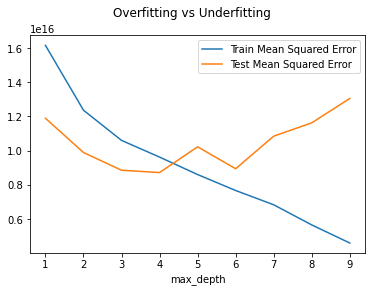

In [ ]:
df_model_1_max_depth["mse_train"].plot(label="Train Mean Squared Error")
df_model_1_max_depth["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

Como cabría esperar, a más profundidad menor es el error cuadrático medio en el conjunto de entrenamiento. De hecho, esperaríamos que este error fuese 0 si la profundidad fuese lo suficientemente grande. Si nos fiásemos de este criterio, caeríamos en overfitting, ya que como observamos, esto no se cumple para el conjunto test.

El resultado más interesante ocurre en el conjunto test, donde se aprecia un valle para max_depth = 4. Por lo tanto, el mejor árbol de decisión ocurre con 4 niveles. Por debajo de este valor, esperamos que nuestros modelos presenten underfitting y sean demasiado simples para elaborar predicciones acertadas.

Echemos un vistazo al score, también llamado coeficiente de determinación:

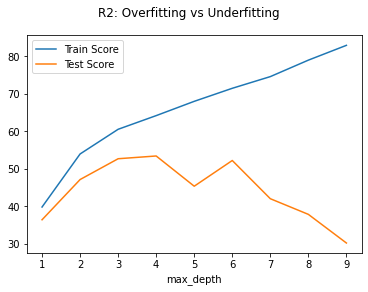

In [ ]:
df_model_1_max_depth["score_train"].plot(label="Train Score")
df_model_1_max_depth["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

Esta vez vemos que el *score* del conjunto de entreno sigue una función monónota creciente, tal y como cabría esperar. Dada una profundidad suficiente, alcanzaríamos un score de 100.

En el conjunto test, la función tiene un pico en el valor max_depth = 4. Con 4 niveles, tenemos el mejor poder explicativo. 

En la siguiente tabla, se resumen los datos obtenidos:

In [ ]:
df_model_1_max_depth

,score_train,score_test,mse_train,mse_test
max_depth,,,,
1,39.814426,36.418519,1.616028e+16,1.189476e+16
2,53.947557,47.135198,1.236543e+16,9.889897e+15
3,60.524869,52.678403,1.059937e+16,8.852879e+15
4,64.165175,53.411347,9.621919e+15,8.715761e+15
5,67.970284,45.358878,8.600219e+15,1.022221e+16
6,71.444001,52.209720,7.667500e+15,8.940560e+15
7,74.558148,42.027934,6.831328e+15,1.084536e+16
8,78.945943,37.856910,5.653172e+15,1.162567e+16
9,82.889097,30.226663,4.594406e+15,1.305313e+16


### Elección por min_samples_leaf

Realizamos el mismo procedimiento teniendo en cuenta el parámetro *min_samples_leaf*. Esto fija la mínima cantidad de muestras por hoja en nuestro árbol.

In [ ]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for min_samples_leaf in list(range(1,41,1)):
  tree_model = DecisionTreeRegressor(random_state=0, min_samples_leaf=min_samples_leaf)
  tree_model.fit(X1_train, y1_train)

  pred_train = tree_model.predict(X1_train)
  pred_test = tree_model.predict(X1_test)

  ## Generación de listas
  md_list.append(min_samples_leaf)
  score_train_list.append(100.0*tree_model.score(X1_train, y1_train))
  score_test_list.append(100.0*tree_model.score(X1_test, y1_test))
  mse_train_list.append(mean_squared_error(y1_train, pred_train))
  mse_test_list.append(mean_squared_error(y1_test, pred_test))

df_model_1_min_samples_leaf = pd.DataFrame({"min_samples_leaf":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

In [ ]:
df_model_1_min_samples_leaf.set_index("min_samples_leaf", inplace=True)

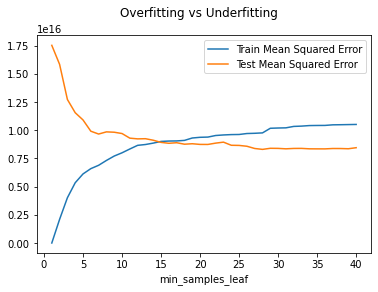

In [ ]:
df_model_1_min_samples_leaf["mse_train"].plot(label="Train Mean Squared Error")
df_model_1_min_samples_leaf["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

Como podemos ver, cuando el mínimo de muestras permitido por hoja es muy bajo, el error en el conjunto de entrenamiento es muy pequeño. Sin embargo, es máximo en el conjunto de test. Claramente estos árboles presentan overfitting, ya que funcionan muy bien para el conjunto de entrenamiento pero no para el de test.

Conforme vamos aumentando el número de muestras permitido por hoja, ambas funciones van convergiendo a un valor de error medio. Esto quiere decir que nuestro árbol empieza a ser igual de bueno prediciendo sobre el conjunto de entrenamiento que sobre el conjunto de pruebas.

Representando el coeficiente de determinación:

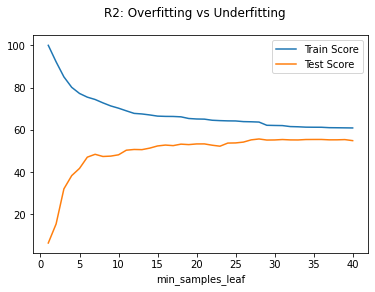

In [ ]:
df_model_1_min_samples_leaf["score_train"].plot(label="Train Score")
df_model_1_min_samples_leaf["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

Análogamente al error cuadrático medio, para un mínimo de muestras por hoja pequeño, nuestro modelo no es capaz de predecir bien el conjunto test, y sí en el conjunto de entrenamiento. Por lo tanto, estos modelos presentarán overfitting y no son de gran interés.

Al aumentar el número de muestras por hoja observamos que ambas funciones vuelven a converger. Son estos modelos los que nos ofrecerán mejores predicciones ante conjuntos de datos nuevos.

Resumimos en una tabla los resultados:

In [ ]:
df_model_1_min_samples_leaf

,score_train,score_test,mse_train,mse_test
min_samples_leaf,,,,
1,100.000000,6.337400,0.000000e+00,1.752231e+16
2,92.188012,15.355916,2.097577e+15,1.583513e+16
3,85.055114,31.993789,4.012814e+15,1.272254e+16
4,80.105980,38.268298,5.341694e+15,1.154871e+16
5,77.197845,41.689126,6.122550e+15,1.090874e+16
6,75.449481,47.017981,6.591999e+15,9.911826e+15
7,74.341342,48.367790,6.889542e+15,9.659304e+15
8,72.745074,47.338238,7.318152e+15,9.851912e+15
9,71.289412,47.508264,7.709008e+15,9.820104e+15


### Analisis de resultados

Comparamos los modelos por su coeficiente de determinación (score_test) y elegimos aquel que tenga un valor mayor:

In [ ]:
df_model_1_max_depth[df_model_1_max_depth["score_test"] == max(df_model_1_max_depth["score_test"])]

,score_train,score_test,mse_train,mse_test
max_depth,,,,
4,64.165175,53.411347,9.621919e+15,8.715761e+15


In [ ]:
df_model_1_min_samples_leaf[df_model_1_min_samples_leaf["score_test"] == max(df_model_1_min_samples_leaf["score_test"])]

,score_train,score_test,mse_train,mse_test
min_samples_leaf,,,,
28,63.644846,55.634474,9.761632e+15,8.299860e+15


Por lo tanto, nos quedamos con *min_samples_leaf = 28*

In [ ]:
from sklearn.tree import plot_tree
tree_model_final_1 = DecisionTreeRegressor(random_state=0, min_samples_leaf=28)
tree_model_final_1.fit(X1_train, y1_train)
pred_train = tree_model_final_1.predict(X1_train)
print (r2_score(y1_train, pred_train))

0.6364484588949433


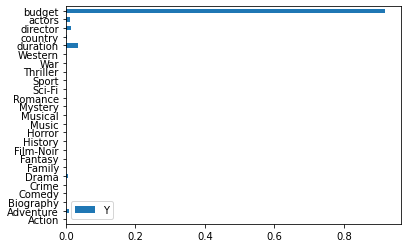

In [ ]:
df_imp = pd.DataFrame(tree_model_final_1.feature_importances_.reshape(1,-1), columns=X1.columns, index=["Y"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Tal y como vemos, la variable decisiva es *budget* seguido de *duration*. Podemos intuir a que hay una dependencia proporcional entre el presupuesto y la duración de una película y lo que finalmente acaba recaudando. Comunmente se observa que los largometrages famosos son aquellos que más presupuesto tienen y los que más han recaudado (The Avengers, Interstellar, Star wars...) debido, en parte, a sus grandes campañas publicitarias.

Por tanto, esperamos ver un árbol con bifurcaciones atendiendo esencialmente a esas dos variables:

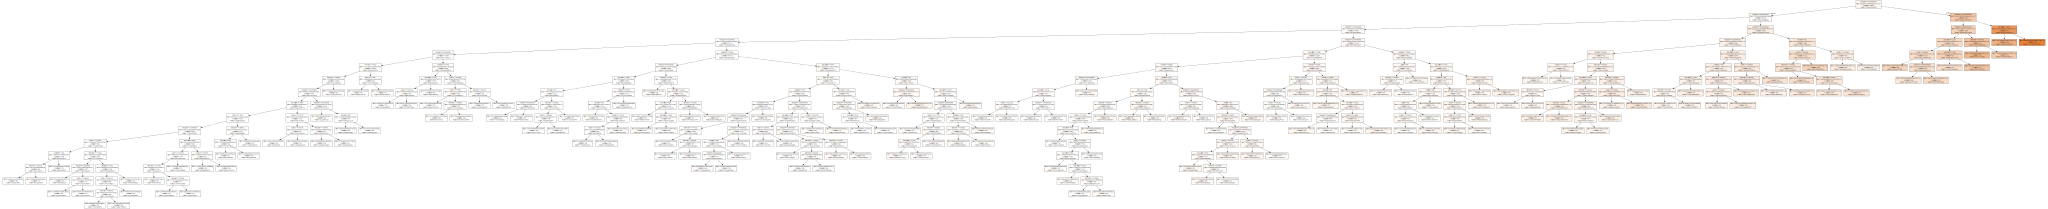

In [ ]:
import graphviz
dot_data = export_graphviz(tree_model_final_1, out_file=None, 
                                feature_names=X1.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png")

### Predicción:

Elegimos 2 películas que pertenezcan al conjunto de datos y calculamos el *worlwide_gross_income* utilizando el modelo obtenido anteriormente:

* **The Girl on the Train (2016)**

In [ ]:
df_final[df_final["original_title"].str.contains("The Girl on the Train")]

,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
7413,tt2387589,The Girl on the Train,2014,"Action, Thriller",80,807,2266,1428,4.3,893,5.61,28000000.0,3124.0,22,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7862,tt3631112,The Girl on the Train,2016,"Crime, Drama, Mystery",112,972,3685,1124,6.5,164886,6.49,45000000.0,173185856.0,488,371,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
pelicula1 = df_final[df_final["original_title"].str.contains("The Girl on the Train")].iloc[[1]]

X_pelicula_1_model_1 = pelicula1[X1.columns]

tree_model_final_1.predict(X_pelicula_1_model_1)[0]

106060048.72

Obenemos una predicción de 106060048 \$, un valor inferior al valor real de 173185856 \$. Podemos decir que ambas están dentro del mismo orden magnitud.



* **Transcendence**

In [ ]:
df_final[df_final["original_title"].str.contains("Transcendence")]

,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
7254,tt2209764,Transcendence,2014,"Action, Drama, Sci-Fi",119,640,3921,1889,6.3,213720,6.3,100000000.0,103039256.0,554,373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
pelicula2 = df_final[df_final["original_title"].str.contains("Transcendence")].iloc[[0]]

X_pelicula_2_model_1 = pelicula2[X1.columns]

tree_model_final_1.predict(X_pelicula_2_model_1)[0]

226283147.73913044

En este caso, nuestra predicción arroja 226283147 \$, mismo orden de magnitud que el valor real de 103039256 \$. Nuestra predicción da un valor por encima del real.

## Modelo 2: Predicción de avg_vote_weighted

Estimamos la media ponderada de los votos en IMDB (avg_vote_weighted) usando un árbol de decisión, atendiendo a las variables: genre, duration, country, director, actors, budget, worldwide_gross_income, reviews_from_users y reviews_from_critics. Dividimos el conjunto de datos en un subconjunto de entreno (70%) y otro de prueba (30%):

In [ ]:
X2 = df_final[['Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', "duration", "country", "director", "actors", "budget", "worlwide_gross_income", "reviews_from_users",  "reviews_from_critics"]]
y2 = df_final["avg_vote_weighted"]

In [ ]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2.values, y2.values, 
                                                    random_state=42, test_size=0.3)
print (X2_train.shape, y2_train.shape)
print (X2_test.shape, y2_test.shape)

(6064, 28) (6064,)
(2600, 28) (2600,)


### Elección por max_depth

Mediante un bucle generamos varios modelos con diferente profundidad. Calculamos, para cada uno de ellos, el coeficiente de determinanción y el error cuadrático medio, tanto para el subconjunto de entrenamiento como para el de pruebas:

In [ ]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model.fit(X1_train, y1_train)

  pred_train = tree_model.predict(X1_train)
  pred_test = tree_model.predict(X1_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X1_train, y1_train))
  score_test_list.append(100.0*tree_model.score(X1_test, y1_test))
  mse_train_list.append(mean_squared_error(y1_train, pred_train))
  mse_test_list.append(mean_squared_error(y1_test, pred_test))

df_model_2_maxdepth = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

df_model_2_maxdepth.set_index("max_depth", inplace=True)

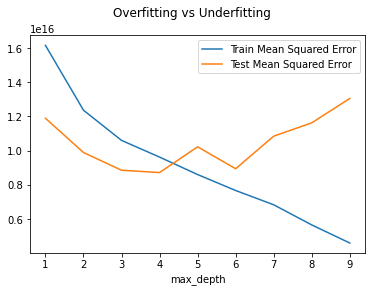

In [ ]:
df_model_2_maxdepth["mse_train"].plot(label="Train Mean Squared Error")
df_model_2_maxdepth["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

Al igual que en el modelo 1, el error en el conjunto de entrenamiendo va siendo menor a medida que vamos incrementando la profundidad de nuestro árbol. Sobre nuestro conjunto de pruebas, el error alcanza un mínimo para el valor de profundidad 4.

Así, para valores inferiores a 4 nuestros modelos presentan underfitting, no contienen la suficiente complejidad para representar todo lo bien que podrían nuestro conjunto de datos. Por otro lado, para profundidades superiores a 4 los modelos presentan overfitting en el conjunto de entrenamiento, ya que sobre este el error va tendiendo a 0 a medida que el arbol va siendo más complejo, pero sube en el subconjunto de pruebas. 

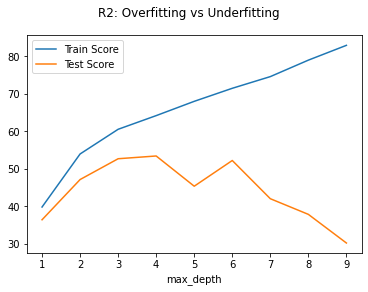

In [ ]:
df_model_2_maxdepth["score_train"].plot(label="Train Score")
df_model_2_maxdepth["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

Conclusiones análogas al modelo 1 se obtienen de este gráfico.

In [ ]:
df_model_2_maxdepth

,score_train,score_test,mse_train,mse_test
max_depth,,,,
1,39.814426,36.418519,1.616028e+16,1.189476e+16
2,53.947557,47.135198,1.236543e+16,9.889897e+15
3,60.524869,52.678403,1.059937e+16,8.852879e+15
4,64.165175,53.411347,9.621919e+15,8.715761e+15
5,67.970284,45.358878,8.600219e+15,1.022221e+16
6,71.444001,52.209720,7.667500e+15,8.940560e+15
7,74.558148,42.027934,6.831328e+15,1.084536e+16
8,78.945943,37.856910,5.653172e+15,1.162567e+16
9,82.889097,30.226663,4.594406e+15,1.305313e+16


### Elección por min_samples_leaf

Analógamente al procedimiento seguido para seleccionar el primer modelo, vamos a tener en cuenta otro parámetro: 


In [ ]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for min_samples_leaf in list(range(1,51,1)):
  tree_model = DecisionTreeRegressor(random_state=0, min_samples_leaf=min_samples_leaf)
  tree_model.fit(X1_train, y1_train)

  pred_train = tree_model.predict(X1_train)
  pred_test = tree_model.predict(X1_test)

  ## Generación de listas
  md_list.append(min_samples_leaf)
  score_train_list.append(100.0*tree_model.score(X1_train, y1_train))
  score_test_list.append(100.0*tree_model.score(X1_test, y1_test))
  mse_train_list.append(mean_squared_error(y1_train, pred_train))
  mse_test_list.append(mean_squared_error(y1_test, pred_test))

df_model_2_min_samples_leaf = pd.DataFrame({"min_samples_leaf":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

df_model_2_min_samples_leaf.set_index("min_samples_leaf", inplace=True)

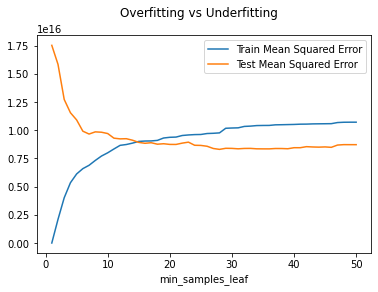

In [ ]:
df_model_2_min_samples_leaf["mse_train"].plot(label="Train Mean Squared Error")
df_model_2_min_samples_leaf["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

Para un número de *min_samples_leaf* pequeño nuestros modelos presentan overfitting. El error es mucho menor en el conjunto de entreno que el conjunto de pruebas. Para valores superiores a 10, el error en ambos conjuntos se reducen.

Si tenemos en cuenta el coeficiente de determinación:

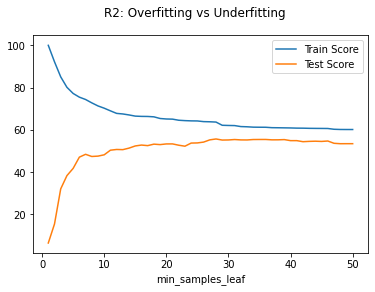

In [ ]:
df_model_2_min_samples_leaf["score_train"].plot(label="Train Score")
df_model_2_min_samples_leaf["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

Observamos que para un número de *min_samples_leaf* pequeño, el coeficiente de determinación es mucho mayor en el conjunto de entreno que en el conjunto de prueba. Por lo tanto, estos modelos padecen de overfitting.

Como se observa, conforme aumenta el número de muestras por hoja permitido, los modelos comienzan a comportarse de forma parecida tanto en el conjunto de entrenamiento como en el conjunto de prueba.

A continuación, recogemos en la siguiente tabla los valores:



In [ ]:
df_model_2_min_samples_leaf

,score_train,score_test,mse_train,mse_test
min_samples_leaf,,,,
1,100.000000,6.337400,0.000000e+00,1.752231e+16
2,92.188012,15.355916,2.097577e+15,1.583513e+16
3,85.055114,31.993789,4.012814e+15,1.272254e+16
4,80.105980,38.268298,5.341694e+15,1.154871e+16
5,77.197845,41.689126,6.122550e+15,1.090874e+16
6,75.449481,47.017981,6.591999e+15,9.911826e+15
7,74.341342,48.367790,6.889542e+15,9.659304e+15
8,72.745074,47.338238,7.318152e+15,9.851912e+15
9,71.289412,47.508264,7.709008e+15,9.820104e+15


### Análisis de resultados

Escogemos los modelos con mejor coeficiente de determinación en el conjunto de pruebas:

In [ ]:
df_model_2_maxdepth[df_model_2_maxdepth["score_test"] == max(df_model_2_maxdepth["score_test"])]

,score_train,score_test,mse_train,mse_test
max_depth,,,,
4,64.165175,53.411347,9.621919e+15,8.715761e+15


In [ ]:
df_model_2_min_samples_leaf[df_model_2_min_samples_leaf["score_test"] == max(df_model_2_min_samples_leaf["score_test"])]

,score_train,score_test,mse_train,mse_test
min_samples_leaf,,,,
28,63.644846,55.634474,9.761632e+15,8.299860e+15


Entre estos dos, el mejor vuelve a ser aquel con *min_samples_leaf = 28*:

In [ ]:
from sklearn.tree import plot_tree
tree_model_final_2 = DecisionTreeRegressor(random_state=0, min_samples_leaf=28)
tree_model_final_2.fit(X2_train, y2_train)
pred_train = tree_model_final_2.predict(X2_train)
print (r2_score(y2_train, pred_train))

0.5231654046270622


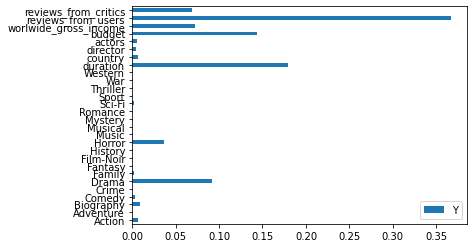

In [ ]:
df_imp = pd.DataFrame(tree_model_final_2.feature_importances_.reshape(1,-1), columns=X2.columns, index=["Y"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

A diferencia del modelo anterior, donde la variable *budget* explicaba más del 90% de nuestra variable dependiente, aquí observamos como los pesos se reparten. La variable *reviews_from_users*, seguida de *duration* y *budget* son las variables fundamentales que contribuyen a explicar la nota media ponderada. Esto puede ser debido a que la métrica que usa IMDB incluya de alguna forma el número de usuarios y críticos expertos que dan su opinión.

Además, observamos que los géneros *drama* y *horror* también son relevantes. Una posible causa podría ser que los usuarios y los expertos tienden a valorar más este tipo de películas o a que hay más películas con esas dos categorías. 

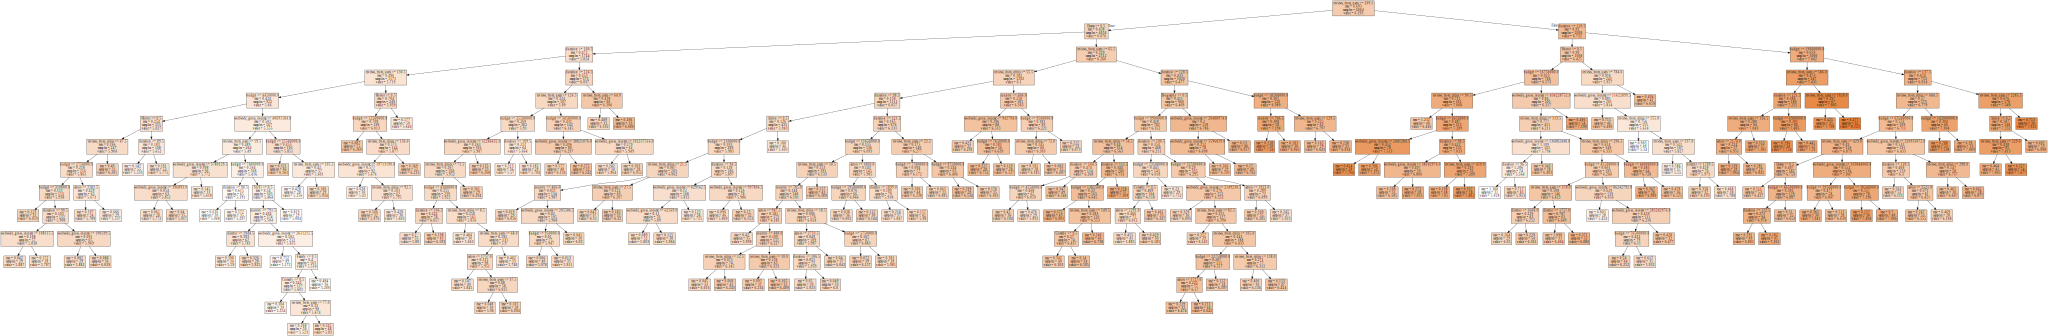

In [ ]:
import graphviz
dot_data = export_graphviz(tree_model_final_2, out_file=None, 
                                feature_names=X2.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png")

### Predicción:

Aplicamos nuestro algoritmo sobre las dos películas anteriores:

In [ ]:
df_final[df_final["original_title"].str.contains("The Girl on the Train")]

,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
7413,tt2387589,The Girl on the Train,2014,"Action, Thriller",80,807,2266,1428,4.3,893,5.61,28000000.0,3124.0,22,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7862,tt3631112,The Girl on the Train,2016,"Crime, Drama, Mystery",112,972,3685,1124,6.5,164886,6.49,45000000.0,173185856.0,488,371,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
X_pelicula_1 = df_final[df_final["original_title"].str.contains("The Girl on the Train")].iloc[[1]]

X_pelicula_1_model_2 = X_pelicula_1[X2.columns]

tree_model_final_2.predict(X_pelicula_1_model_2)[0]

7.065625

Obtenemos una predicción de 7.07, un valor superior al valor real de 6.49.

* **Transcendence**

In [ ]:
df_final[df_final["original_title"].str.contains("Transcendence")]

,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,Action,Adventure,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
7254,tt2209764,Transcendence,2014,"Action, Drama, Sci-Fi",119,640,3921,1889,6.3,213720,6.3,100000000.0,103039256.0,554,373,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
X_pelicula_2 = df_final[df_final["original_title"].str.contains("Transcendence")].iloc[[0]]

X_pelicula_2_model_2 = X_pelicula_2[X2.columns]

tree_model_final_2.predict(X_pelicula_2_model_2)[0]

6.555283018867923

En este caso, nuestra predicción arroja 6.56. Nuestra predicción vuelve a dar un valor por encima del real, 6.3.